<a href="https://colab.research.google.com/github/GrzegorzPiedel/DataScience-portfolio/blob/main/SP500%20Time%20Series%20Forecasting%20with%20LSTM%20and%20GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
import os
os.listdir()

Saving sp500.txt to sp500.txt


['.config', 'sp500.txt', 'sample_data']

In [ ]:
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
keras.utils.set_random_seed(43)
tf.config.experimental.enable_op_determinism()

df = pd.read_csv('sp500.txt')
df = df.sort_values('Date')

data = df["Close"].values.reshape(-1, 1) # tutaj robimy reshape bo MinMaxScaler by krzyczał że mu się nie podoba format

# shuffle=True oznacza: wymieszaj dane losowo przed podziałem
# shuffle=False oznacza: nie mieszaj – zostaw w takiej kolejności, jak są
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [ ]:
def create_sequences(data, seq_length):
    '''
    Funkcja create_sequences przygotowuje dane do modelu analizującego szeregi czasowe.

    Co robi:
    - Tworzy sekwencje (okna) o długości `seq_length` z wejściowych danych `data`
    - Każda sekwencja to X (dane wejściowe)
    - Wartość bezpośrednio po sekwencji to y (cel do przewidzenia)

    Przykład działania:
    Dla data = [10, 11, 12, 13, 14], seq_length = 3
    -> X = [[10, 11, 12], [11, 12, 13]]
    -> y = [13, 14]

    Parametry:
    - data: tablica numpy (np. ceny)
    - seq_length: liczba dni/obserwacji w jednej sekwencji

    Zwraca:
    - X: tablica wejściowa (sekwencje)
    - y: tablica wyjściowa (następna wartość po każdej sekwencji)
    '''

    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [ ]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
from keras_tuner import RandomSearch

# === FUNKCJA: buduje model LSTM ===
def build_lstm_model(hp):
    # hp = obiekt, który pozwala dobrać różne wartości (np. ile neuronów)
    model = Sequential()

    # Pierwsza warstwa LSTM – hp.Int wybiera liczbę neuronów (np. 32, 64, 96, 128)
    model.add(LSTM(hp.Int('lstm1', 32, 128, step=32), return_sequences=True, input_shape=(seq_length, 1)))

    # Normalizacja – pomaga w szybszym i stabilniejszym uczeniu
    model.add(BatchNormalization())

    # Dropout – "wyrzuca" część danych losowo, żeby model się nie przeuczył
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    # Druga warstwa LSTM – znowu losowana liczba neuronów
    model.add(LSTM(hp.Int('lstm2', 32, 128, step=32)))

    # Drugi dropout
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    # Warstwa wyjściowa – Dense(1) = model ma przewidzieć 1 liczbę (kolejną cenę)
    model.add(Dense(1))

    # Kompilacja modelu – Adam to sposób uczenia, mse to funkcja błędu (średni kwadrat różnicy)
    model.compile(optimizer=Adam(), loss='mse')

    return model

# === KERAS TUNER: Szukanie najlepszego modelu LSTM ===
tuner_lstm = RandomSearch(
    build_lstm_model,            # funkcja budująca model
    objective='val_loss',        # celem jest jak najmniejszy błąd walidacyjny
    max_trials=3,                # przetestuj 3 różne wersje
    executions_per_trial=1,      # każdą wersję testuj tylko raz
    directory="lstm",            # katalog na wyniki
    project_name="lstm",         # nazwa projektu
    seed=42                      # stałe losowanie (żeby wyniki były powtarzalne)
)

"""
👉 Wcześniejszy podział train_test_split(..., shuffle=False) tworzy dane treningowe i testowe.
👉 Ale KerasTuner potrzebuje jeszcze osobnego zestawu walidacyjnego do sprawdzania, jak dobrze uczy się model w trakcie treningu.
👉 Dlatego z X_train i y_train tworzymy X_train2 (trening) i X_val (walidacja).
"""

val_split = int(len(X_train) * 0.1)
X_val, y_val = X_train[-val_split:], y_train[-val_split:]
X_train2, y_train2 = X_train[:-val_split], y_train[:-val_split]

# === Uruchamiamy wyszukiwanie najlepszego modelu LSTM ===
tuner_lstm.search(
    X_train2, y_train2,                     # dane treningowe
    validation_data=(X_val, y_val),         # dane walidacyjne
    epochs=10,                              # liczba epok (ile razy model uczy się na tych samych danych)
    batch_size=32                           # batch_size = ile próbek na raz jest podawanych do modelu
)

# Najlepszy model LSTM po tuningu
best_lstm = tuner_lstm.get_best_models(1)[0]

tuner_gru = RandomSearch(
    build_gru_model,
    objective = 'val_loss',
    max_trials=3,
    executions_per_trial = 1,
    directory="gru",
    project_name="gru",
    seed=42
)

# Uruchamiamy wyszukiwanie najlepszego modelu GRU
tuner_gru.search(
    X_train2, y_train2,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

best_gru = tuner_gru.get_best_models(1)[0]

Trial 3 Complete [00h 01m 41s]
val_loss: 0.02752295508980751

Best val_loss So Far: 0.023340074345469475
Total elapsed time: 00h 04m 47s


In [ ]:
pred_lstm = scaler.inverse_transform(best_lstm.predict(X_test))
pred_gru = scaler.inverse_transform(best_gru.predict(X_test))
y_test_inv = scaler.inverse_transform(y_test)

"""
Objaśnienie:
model_lstm.predict(X_test) – model przewiduje ceny na podstawie danych testowych. Ale te wartości są jeszcze zeskalowane (bo wcześniej dane były przeskalowane do zakresu 0–1).
scaler.inverse_transform(...) – przywraca oryginalną skalę (czyli prawdziwe wartości cen SP500).
"""

import numpy as np
from sklearn.metrics import mean_squared_error

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, pred_lstm))
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, pred_gru))

print("RMSE LSTM: ", rmse_lstm)
print("RMSE GRU: ", rmse_gru)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
RMSE LSTM:  33.47743837371799
RMSE GRU:  27.20279321650865


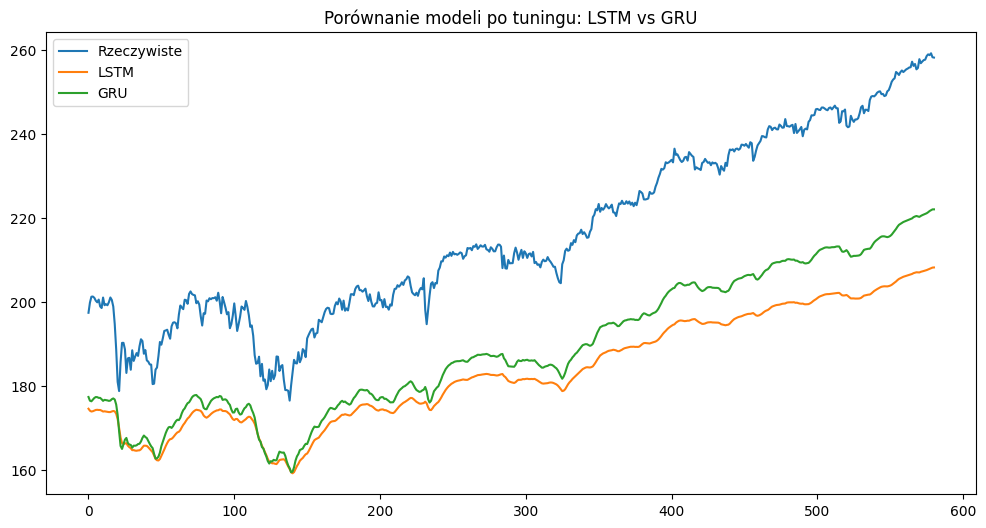

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Rzeczywiste")
plt.plot(pred_lstm, label="LSTM")
plt.plot(pred_gru, label="GRU")
plt.legend()
plt.title("Porównanie modeli po tuningu: LSTM vs GRU")
plt.show()